In [1]:
# This source code is provided for the purposes of scientific reproducibility
# under the following limited license from Element AI Inc. The code is an
# implementation of the N-BEATS model (Oreshkin et al., N-BEATS: Neural basis
# expansion analysis for interpretable time series forecasting,
# https://arxiv.org/abs/1905.10437). The copyright to the source code is
# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/.  Any commercial use (whether
# for the benefit of third parties or internally in production) requires an
# explicit license. The subject-matter of the N-BEATS model and associated
# materials are the property of Element AI Inc. and may be subject to patent
# protection. No license to patents is granted hereunder (whether express or
# implied). Copyright © 2020 Element AI Inc. All rights reserved.

"""
Traffic Experiment
"""
import logging
import os
from typing import Dict

import gin
import numpy as np
import pandas as pd
import torch as t
from fire import Fire
import pickle

from common.experiment import Experiment
from common.sampler import TimeseriesSampler
from common.torch.ops import to_tensor
from common.torch.snapshots import SnapshotManager
from datasets.traffic import TrafficDataset, TrafficMeta
from experiments.model import generic, interpretable
from experiments.trainer import trainer

splits = {
    # # https://arxiv.org/pdf/1704.04110.pdf
    # 'deepar': '2008-06-14 23',
    # # Figure B.5 http://proceedings.mlr.press/v97/wang19k/wang19k-supp.pdf
    # 'deepfactors': '2008-01-13 23',
    # the last 7 days according to our holidays assumption
    'last': '2009-03-24 00'
}
test_windows = 7

## Dataset load
- 963 time-series (length of each time series: 10560 fixed)
- hourly data (seasonality: 24; 1 day)
- Forecast Horizon: 168 (train: H=24)
- train: (963, 10392), test: (963, 168)

## Train

In [2]:
class TrafficExperiment(Experiment):
    @gin.configurable()
    def instance(self,
                 repeat: int,
                 lookback: int,
                 loss: str,
                 history_size: int,
                 iterations: Dict[str, int],
                 model_type: str):

        for split_name, split_date in splits.items():
            horizon = TrafficMeta.horizon
            input_size = lookback * horizon

            # Training Set
            with open('../dataset/nbeats/TrafficDataset_train.pkl.', 'rb') as f:
                training_set = pickle.load(f)
            with open('../dataset/nbeats/TrafficDataset_test.pkl.', 'rb') as f:
                test_set = pickle.load(f)
            
            training_values = training_set['values']
            test_values = test_set['values']
            
            training_set = TimeseriesSampler(timeseries=training_values,
                                             insample_size=input_size,
                                             outsample_size=horizon,
                                             window_sampling_limit=history_size * horizon)

            if model_type == 'interpretable':
                model = interpretable(input_size=input_size, output_size=horizon)
            elif model_type == 'generic':
                model = generic(input_size=input_size, output_size=horizon)
            else:
                raise Exception(f'Unknown model type {model_type}')

            print('Training start')
            # Train model
            snapshot_manager = SnapshotManager(snapshot_dir=os.path.join(self.root, 'snapshots', split_name),
                                               total_iterations=iterations[split_name])
            model = trainer(snapshot_manager=snapshot_manager,
                            model=model,
                            training_set=iter(training_set),
                            timeseries_frequency=TrafficMeta.frequency,
                            loss_name=loss,
                            iterations=iterations[split_name])

            # Build forecasts
            forecasts = []
            model.eval()
            with t.no_grad():
                for i in range(test_windows):
                    window_input_set = np.concatenate([training_values, test_values[:, :i * TrafficMeta.horizon]],
                                                      axis=1)
                    input_set = TimeseriesSampler(timeseries=window_input_set,
                                                  insample_size=input_size,
                                                  outsample_size=horizon,
                                                  window_sampling_limit=int(
                                                      history_size * horizon))
                    x, x_mask = map(to_tensor, input_set.last_insample_window())
                    window_forecast = model(x, x_mask).cpu().detach().numpy()
                    forecasts = window_forecast if len(forecasts) == 0 else np.concatenate([forecasts, window_forecast],
                                                                                           axis=1)

            forecasts_df = pd.DataFrame(forecasts, columns=[f'V{i + 1}'
                                                            for i in range(test_windows * TrafficMeta.horizon)])
            forecasts_df.index.name = 'id'
            forecasts_df.to_csv(os.path.join(self.root, f'forecast_{split_name}.csv'))

In [6]:
exp = TrafficExperiment(config_path='experiments/traffic/interpretable.gin')

In [7]:
gin.parse_config_file(exp.config_path)

ParsedConfigFileIncludesAndImports(filename='experiments/traffic/interpretable.gin', imports=[], includes=[])

In [8]:
exp.instance()

Training start
Iteration 2100/24000, Learning Rate: 0.0010, Training Loss: 17.6359
Iteration 2400/24000, Learning Rate: 0.0010, Training Loss: 15.5648
Iteration 2700/24000, Learning Rate: 0.0010, Training Loss: 14.8468
Iteration 3000/24000, Learning Rate: 0.0010, Training Loss: 24.0413
Iteration 3300/24000, Learning Rate: 0.0010, Training Loss: 16.8442
Iteration 3600/24000, Learning Rate: 0.0010, Training Loss: 13.3753
Iteration 3900/24000, Learning Rate: 0.0010, Training Loss: 14.5820
Iteration 4200/24000, Learning Rate: 0.0010, Training Loss: 12.1117
Iteration 4500/24000, Learning Rate: 0.0010, Training Loss: 13.2509
Iteration 4800/24000, Learning Rate: 0.0010, Training Loss: 15.5361
Iteration 5100/24000, Learning Rate: 0.0010, Training Loss: 13.3536
Iteration 5400/24000, Learning Rate: 0.0010, Training Loss: 12.2363
Iteration 5700/24000, Learning Rate: 0.0010, Training Loss: 13.8174
Iteration 6000/24000, Learning Rate: 0.0010, Training Loss: 12.9963
Iteration 6300/24000, Learning Ra

## Prediction Results

In [6]:
dataset = TrafficDataset.load()
with open('../dataset/nbeats/TrafficDataset_train.pkl.', 'rb') as f:
    training_set = pickle.load(f)
with open('../dataset/nbeats/TrafficDataset_test.pkl.', 'rb') as f:
    test_set = pickle.load(f)
training_values = training_set['values']
test_values = test_set['values']

pred = pd.read_csv(f'experiments/traffic/forecast_last.csv')
pred = pred.set_index('id')

In [62]:
training_values.shape

(963, 10392)

In [63]:
test_values.shape

(963, 168)

In [88]:
import matplotlib.pyplot as plt

def plot_random_sample(training_values, test_values, pred_df):
    horizon = 168
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    for i in range(4):
        ax = axs[i // 2, i % 2] 
        
        random_index = np.random.choice(range(training_values.shape[0]))

        combined_values = np.concatenate((training_values[random_index][-3*horizon:-horizon], test_values[random_index]))
        ax.plot(combined_values, label='Data')

        nan_padding = [np.nan] * (len(combined_values) - len(pred_df.iloc[random_index].values))
        pred_values = np.concatenate((nan_padding, pred_df.iloc[random_index].values))

        ax.plot(pred_values, label='Prediction', color='orange')

        ax.set_title(f'NBEATS (Traffic): Index {random_index}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Values')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

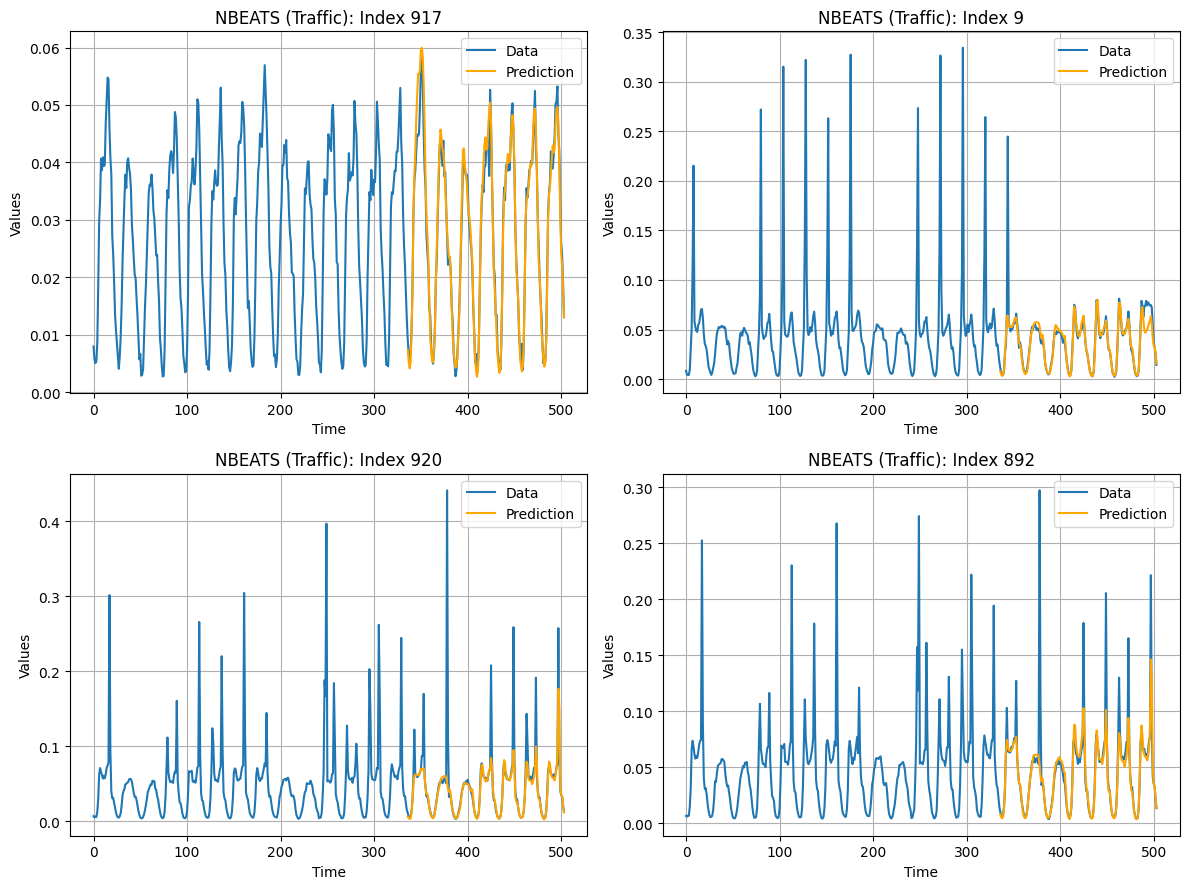

In [89]:
plot_random_sample(training_values, test_values, pred)